In [1]:
from functions import *

# in order to get reproducable results
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)
random.seed(1)

import cmapy
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Only GPU 1 is visible to this code

In [2]:
seis_path = '/data/anyu/beatrice.npy'

In [3]:
seisall = np.load(seis_path)

In [4]:
IL,XL, Z = seisall.shape
print(IL,XL, Z)

901 1861 1200


In [5]:
print(seisall.max(),seisall.min())

185057.19 -203338.81


Make input is IL, Z, XL order.

In [6]:
seisall = np.moveaxis(seisall, 1, -1)
print(seisall.shape)

(901, 1200, 1861)


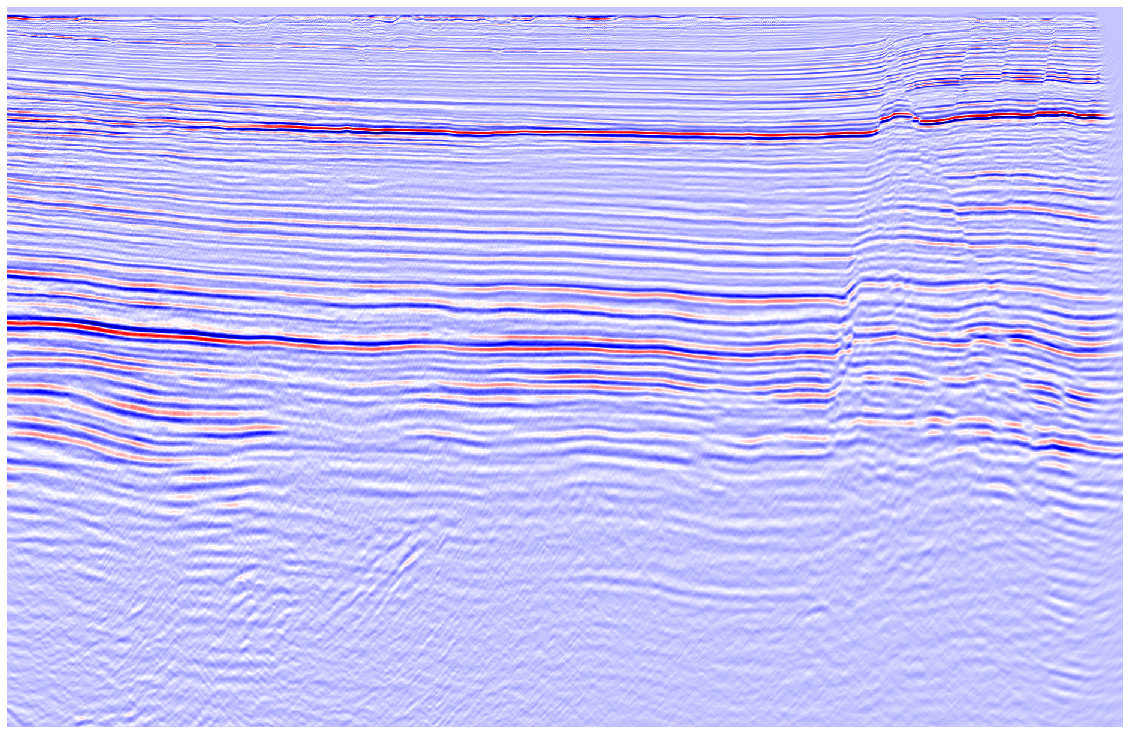

In [7]:
plt.figure(figsize=(20,16))
plt.imshow(seisall[800],cmap='seismic')
# plt.colorbar(shrink=0.5)
plt.axis('off')
# plt.show()
# plt.savefig('beatrice_inline_{}.pdf'.format(8), bbox_inches='tight')
plt.show()

In [8]:
seis_norm = (seisall-seisall.min(axis=(1,2), keepdims=True))/(seisall.max(axis=(1,2), keepdims=True)-seisall.min(axis=(1,2), keepdims=True))
print(seis_norm.shape)

(901, 1200, 1861)


In [9]:
IL,Z,XL = seis_norm.shape
final_predictions = np.zeros((IL,Z,XL))
print(final_predictions.shape)

(901, 1200, 1861)


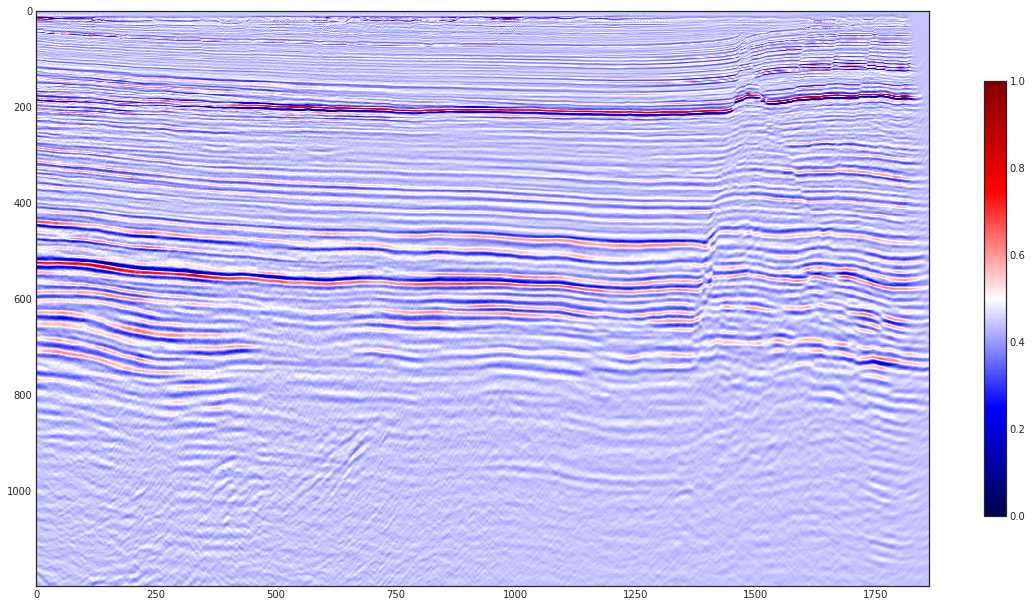

In [10]:
plt.figure(figsize=(20,16))
plt.imshow(seis_norm[800],cmap='seismic')
plt.colorbar(shrink=0.5)
plt.show()

In [11]:
topredict = seis_norm[800]
print(topredict.shape)

(1200, 1861)


(1200, 1861)


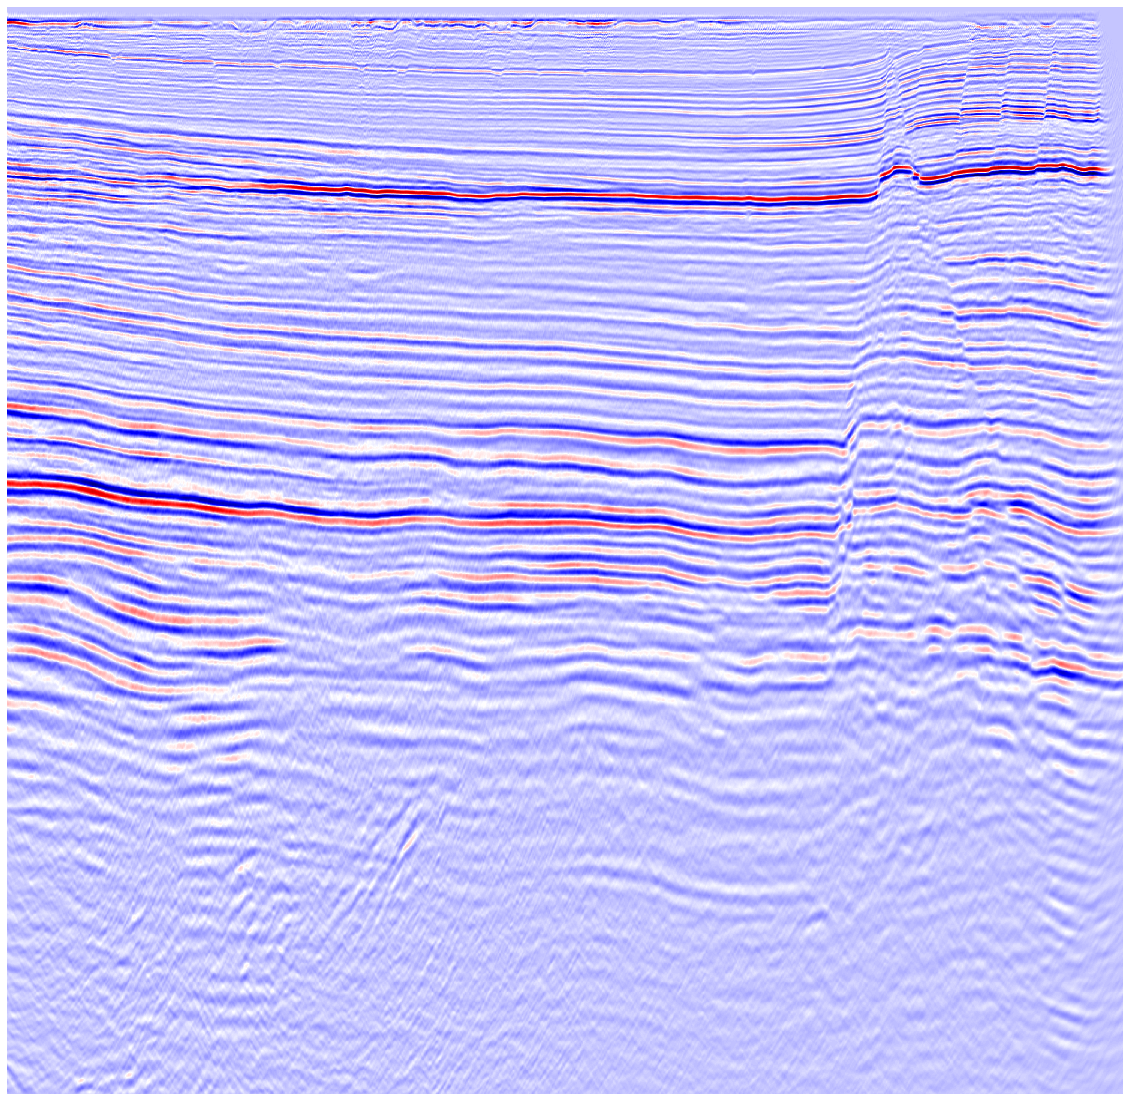

In [12]:
# topredict = cv2.resize(topredict,(1861,2000))
print(topredict.shape)
plt.figure(figsize=(20,20))
plt.imshow(topredict,cmap='seismic',aspect='auto')
# plt.colorbar(shrink=0.5)
plt.axis('off')
plt.show()

In [36]:
im_height = 1200
im_width = 1861
splitsize = 96
stepsize = 48 #overlap half
overlapsize = splitsize-stepsize


# In[ ]:


horizontal_splits_number = int(np.ceil((im_width)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+2*overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+2*overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)


# In[ ]:


horizontal_splits_number = horizontal_splits_number+1
print(horizontal_splits_number)
vertical_splits_number = vertical_splits_number+1
print(vertical_splits_number)


# In[ ]:


halfoverlapsize = int(overlapsize/2)
print(halfoverlapsize)


# In[ ]:


print(len(seis_norm))



# In[ ]:


t_start = time.time()
X_list = []
img = topredict
X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
    
print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.asarray(X_list)
print(X.shape)
print("read images in {} sec".format(time.time()-t_start))

# X_norm = X

# if len(X_norm.shape) == 3:
#     X_norm = np.expand_dims(X_norm, axis=1)
# print(X_norm.shape) #float32


# In[ ]:


X = X.astype(np.float32)
X = np.expand_dims(X,1)
print(X.shape)

class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
#         self.train = train
        self.images = preprocessed_images
#         if self.train:
#             self.masks = preprocessed_masks
# #         self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return image
#         mask = None
#         if self.train:
#             mask = self.masks[idx]
#         return (image, mask)


# In[ ]:


# faults_dataset_test = faultsDataset(X_norm, train=False, preprocessed_masks=None)

# batch_size = 64

# test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
#                                            batch_size=batch_size, 
#                                            shuffle=False)
faults_dataset_test = faultsDataset(X)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)


# In[ ]:


best_iou_threshold = 0.5
modelNo = 2
device = torch.device("cuda")
if modelNo == 0:
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/unet_96_48_900200_seed.model' #unet_96_48_weightloss.model
    save_path = 'unet_96_48_900200_seed_beatrice'
elif modelNo == 1:
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/mobilenet_96_48_900200_seed.model'
    save_path = 'mobilenet_96_48_900200_seed_beatrice'
elif modelNo == 2:
    from model_zoo.HED import HED
    model = HED()
    print("use model HED") #hed_96_48_aug_ShiftScaleRotate.model
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/hed_900200_seed_resize_1537to922.model'
    #'/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/hed_96_48_900200_seed3.model'
    save_path = 'beatricepreds_play'
elif modelNo == 3:
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/rcf_96_48_900200_seed.model'
    save_path = 'rcf_96_48_900200_seed_beatrice'
else:
    from model_zoo.CED import CED
    model = CED()
    print("use model CED")
print(best_model_fpath)
print(save_path)
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# model.cuda();
summary(model, (1, splitsize, splitsize))#,device='cpu')


# In[ ]:


def saveResults(save_path, test_loader, epoch):
    WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
    os.makedirs(save_path, exist_ok=True)

    test_predictions = []
    imageNo = -1
    for images in test_loader:
#         images = Variable(images)
        
        images = Variable(images.cuda())
        outputs = model(images)
        y_preds = outputs
        if modelNo == 2 or modelNo == 21:
            y_preds = outputs[-2]
        elif modelNo == 3:
            y_preds = outputs[-1]
#         predicted_mask = y_preds > best_iou_threshold
        test_predictions.extend(y_preds.detach().cpu())
#         print(test_predictions[0].dtype)
#         print(len(test_predictions))
        if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
            imageNo = imageNo +1
            tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
#             print(tosave.shape)
            test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

            
            tosave = np.moveaxis(tosave,-3,-1)
#             print(tosave.shape)
            tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
#             print(tosave.shape)
#             break
        
            tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
#             print(tosave.shape)

            recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)

            os.makedirs(save_path, exist_ok=True)
#             final_predictions[imageNo] = np.squeeze(recover_Y_test_pred)
            np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred))   
            
# np.save(save_path,final_predictions)          

print("save")
t1 = time.time()
saveResults(save_path, test_loader, 100)
t2 = time.time()
print('save in {} sec'.format(t2-t1))


39
1968
53 54
25
1296
48 48
40
26
24
901
1040
(96, 96)
read images in 0.03735089302062988 sec
(1040, 96, 96)
read images in 0.07137584686279297 sec
(1040, 1, 96, 96)
use model HED
/home/anyu/myproject/venv/an/all_model_new/hed_192_96_900200_seed_resize_96_48.model
beatricepreds_play
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
              ReLU-2           [-1, 32, 96, 96]               0
           Dropout-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 32, 96, 96]           9,248
              ReLU-5           [-1, 32, 96, 96]               0
           Dropout-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          18,496
              ReLU-9           [-1, 64, 48, 48]               0
          D

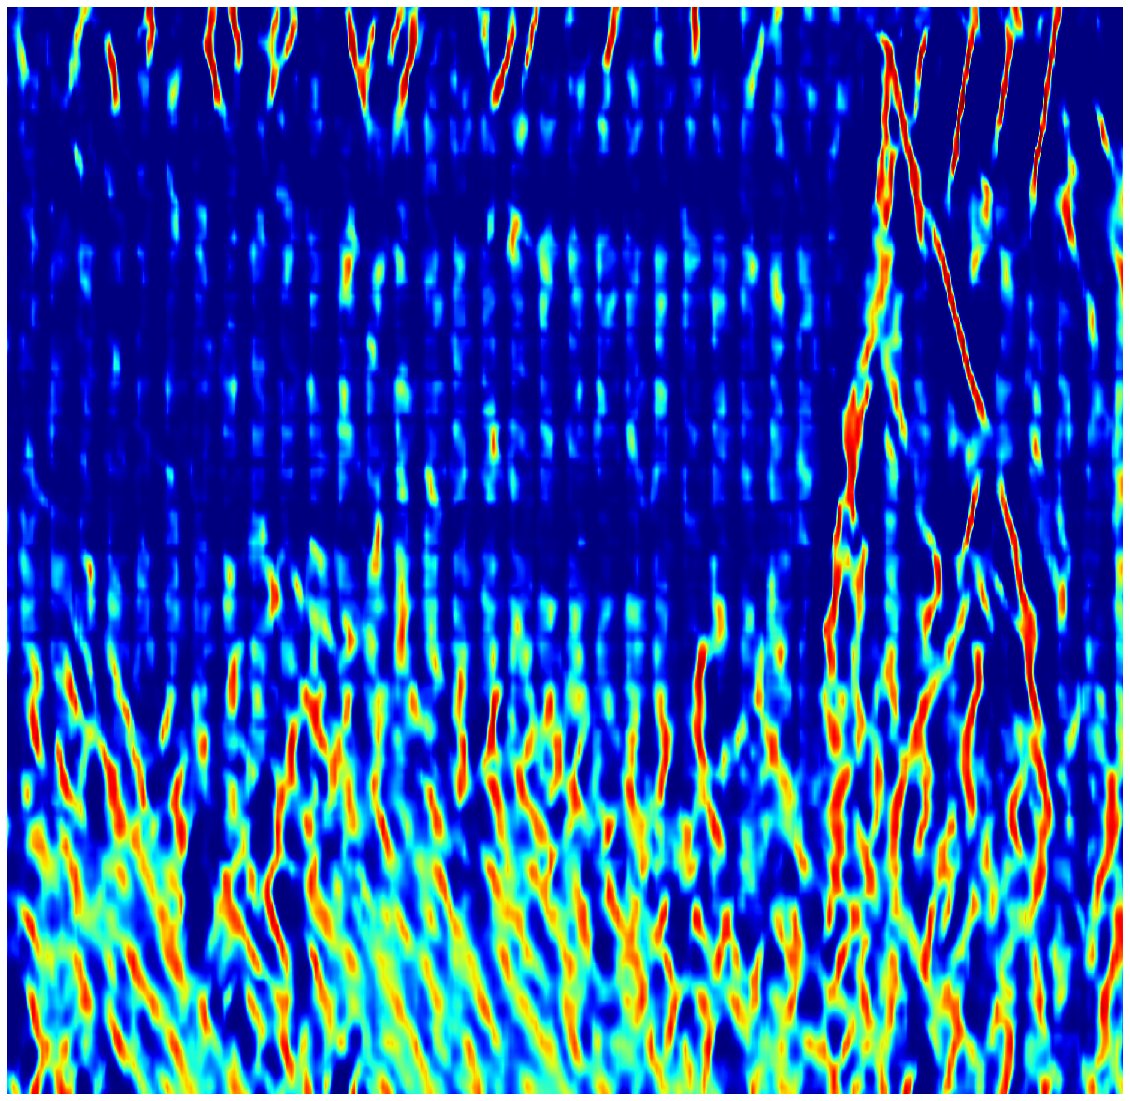

In [37]:
a = np.load(os.path.join(save_path,"0.npy"))
# b = np.load(os.path.join("/home/anyu/myproject/venv/an/pieces/HED/dropout/0.2/testGTs","0.npy"))

import cv2
import cmapy



heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('jet_r'))
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(heatmap_img,aspect='auto')

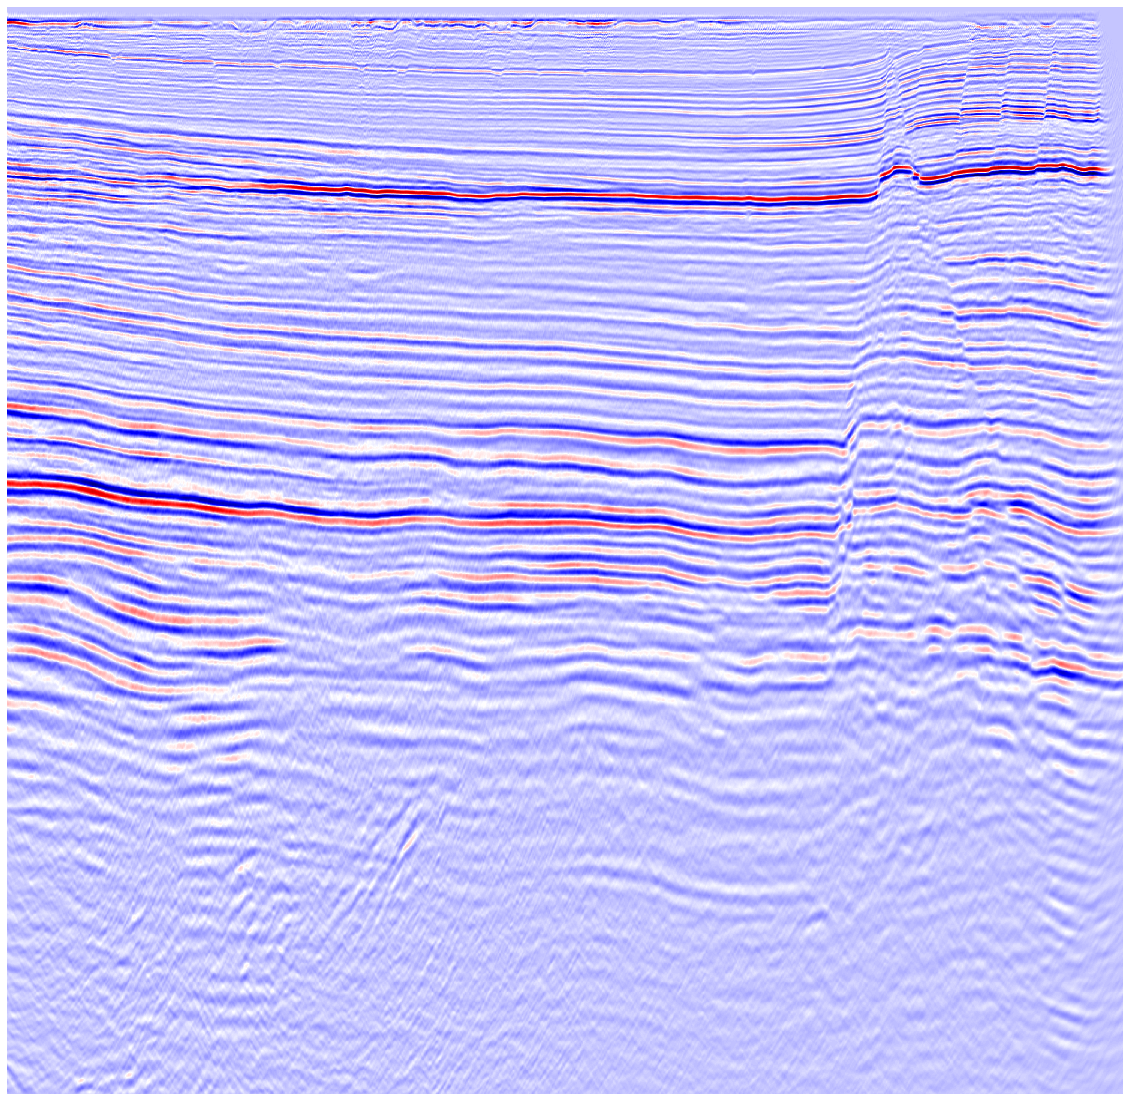

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(topredict,cmap='seismic',aspect='auto')
# plt.colorbar(shrink=0.5)
plt.axis('off')
plt.show()

In [59]:
im_height = Z
im_width = XL
splitsize = 96
stepsize = 48 #overlap half
overlapsize = splitsize-stepsize


# In[ ]:


horizontal_splits_number = int(np.ceil((im_width)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+2*overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+2*overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)


# In[ ]:


horizontal_splits_number = horizontal_splits_number+1
print(horizontal_splits_number)
vertical_splits_number = vertical_splits_number+1
print(vertical_splits_number)


# In[ ]:


halfoverlapsize = int(overlapsize/2)
print(halfoverlapsize)


# In[ ]:


print(len(seis_norm))



# In[ ]:


t_start = time.time()
X_list = []
for i in range(0,len(seis_norm),100):
    img = seis_norm[i]
    X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
    
print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.asarray(X_list)
print(X.shape)
print("read images in {} sec".format(time.time()-t_start))

# X_norm = X

# if len(X_norm.shape) == 3:
#     X_norm = np.expand_dims(X_norm, axis=1)
# print(X_norm.shape) #float32


# In[ ]:


X = X.astype(np.float32)
X = np.expand_dims(X,1)
print(X.shape)

class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
#         self.train = train
        self.images = preprocessed_images
#         if self.train:
#             self.masks = preprocessed_masks
# #         self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return image
#         mask = None
#         if self.train:
#             mask = self.masks[idx]
#         return (image, mask)


# In[ ]:


# faults_dataset_test = faultsDataset(X_norm, train=False, preprocessed_masks=None)

# batch_size = 64

# test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
#                                            batch_size=batch_size, 
#                                            shuffle=False)
faults_dataset_test = faultsDataset(X)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)


# In[ ]:


best_iou_threshold = 0.5
modelNo = 2
device = torch.device("cuda")
if modelNo == 0:
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/unet_96_48_900200_seed.model' #unet_96_48_weightloss.model
    save_path = 'unet_96_48_900200_seed_beatrice'
elif modelNo == 1:
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/mobilenet_96_48_900200_seed.model'
    save_path = 'mobilenet_96_48_900200_seed_beatrice'
elif modelNo == 2:
    from model_zoo.HED import HED
    model = HED()
    print("use model HED") #hed_96_48_aug_ShiftScaleRotate.model
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/augmethod900200seed/hed_96_48_900200_seed_ShiftScaleRotate.model'
    #'/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/hed_96_48_900200_seed3.model'
    save_path = 'beatricepreds/augmethod900200seed/hed_96_48_900200_seed_ShiftScaleRotate'
elif modelNo == 3:
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    best_model_fpath = '/home/anyu/myproject/venv/an/all_model_new/noaugmodelsseed/rcf_96_48_900200_seed.model'
    save_path = 'rcf_96_48_900200_seed_beatrice'
else:
    from model_zoo.CED import CED
    model = CED()
    print("use model CED")
print(best_model_fpath)
print(save_path)
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# model.cuda();
summary(model, (1, splitsize, splitsize))#,device='cpu')


# In[ ]:


def saveResults(save_path, test_loader, epoch):
    WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
    os.makedirs(save_path, exist_ok=True)

    test_predictions = []
    imageNo = -1
    for images in test_loader:
#         images = Variable(images)
        
        images = Variable(images.cuda())
        outputs = model(images)
        y_preds = outputs
        if modelNo == 2 or modelNo == 21:
            y_preds = outputs[-2]
        elif modelNo == 3:
            y_preds = outputs[-1]
#         predicted_mask = y_preds > best_iou_threshold
        test_predictions.extend(y_preds.detach().cpu())
#         print(test_predictions[0].dtype)
#         print(len(test_predictions))
        if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
            imageNo = imageNo +1
            tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
#             print(tosave.shape)
            test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

            
            tosave = np.moveaxis(tosave,-3,-1)
#             print(tosave.shape)
            tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
#             print(tosave.shape)
#             break
        
            tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
#             print(tosave.shape)

            recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)

            os.makedirs(save_path, exist_ok=True)
#             final_predictions[imageNo] = np.squeeze(recover_Y_test_pred)
            np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred))   
            
# np.save(save_path,final_predictions)          

print("save")
t1 = time.time()
saveResults(save_path, test_loader, 100)
t2 = time.time()
print('save in {} sec'.format(t2-t1))


39
1968
53 54
25
1296
48 48
40
26
24
901
10400
(96, 96)
read images in 0.4778785705566406 sec
(10400, 96, 96)
read images in 0.7599821090698242 sec
(10400, 1, 96, 96)
use model HED
/home/anyu/myproject/venv/an/all_model_new/augmethod900200seed/hed_96_48_900200_seed_ShiftScaleRotate.model
beatricepreds/augmethod900200seed/hed_96_48_900200_seed_ShiftScaleRotate
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
              ReLU-2           [-1, 32, 96, 96]               0
           Dropout-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 32, 96, 96]           9,248
              ReLU-5           [-1, 32, 96, 96]               0
           Dropout-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          18,4

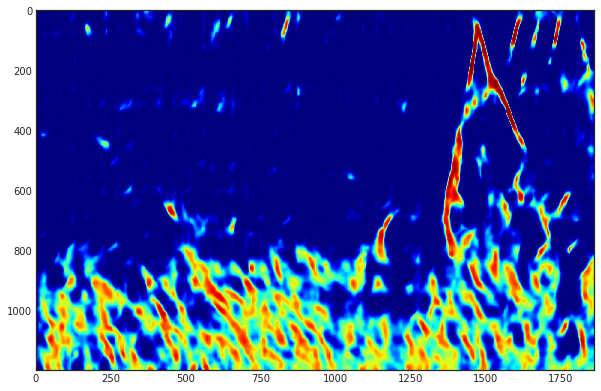

In [60]:
a = np.load(os.path.join(save_path,"8.npy"))
# b = np.load(os.path.join("/home/anyu/myproject/venv/an/pieces/HED/dropout/0.2/testGTs","0.npy"))

import cv2
import cmapy


# In[ ]:


heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('jet_r'))
plt.figure(figsize=(10,8))
plt.imshow(heatmap_img)
# plt.colorbar(shrink=0.5)
# plt.axis('off')
# plt.show()

plt.savefig('{}_8_beatrice.png'.format(save_path))


In [ ]:
exit


In [8]:
seis = seisall[800:801,:,:]
print(seis.shape)

(1, 1200, 1861)


In [9]:
im_height = Z
im_width = XL
splitsize = 96
stepsize = 48
overlapsize = splitsize-stepsize
modelNo = 2
# best_model_fpath = 'hed_checkpoint.pt'
best_iou_threshold = 0.3

In [10]:
horizontal_splits_number = int(np.ceil((im_width-overlapsize)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height-overlapsize)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)

38
1872
5 6
24
1200
0 0


In [11]:
print(len(seis))

1


In [12]:
seis_norm = (seis-seis.min(axis=(1,2), keepdims=True))/(seis.max(axis=(1,2), keepdims=True)-seis.min(axis=(1,2), keepdims=True))
print(seis_norm.shape)

(1, 1200, 1861)


In [13]:
t_start = time.time()
X_list = []
for i in range(len(seis_norm)):
    img = seis_norm[i]
    X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
    
print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.asarray(X_list)
print(X.shape)
print("read images in {} sec".format(time.time()-t_start))

# X_norm = X

# if len(X_norm.shape) == 3:
#     X_norm = np.expand_dims(X_norm, axis=1)
# print(X_norm.shape) #float32

912
(96, 96)
read images in 0.054422616958618164 sec
(912, 96, 96)
read images in 0.08440113067626953 sec


In [14]:
X = X.astype(np.float32)
print(X.shape)
X = np.expand_dims(X,1)
print(X.shape)

(912, 96, 96)
(912, 1, 96, 96)


In [15]:
class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
#         self.train = train
        self.images = preprocessed_images
#         if self.train:
#             self.masks = preprocessed_masks
# #         self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return image
#         mask = None
#         if self.train:
#             mask = self.masks[idx]
#         return (image, mask)

In [16]:
faults_dataset_test = faultsDataset(X)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [17]:
device = torch.device("cuda")
if modelNo == 0:
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    best_model_fpath = 'unet_96_48_noaug.model'
elif modelNo == 1:
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    best_model_fpath = 'mobilenet_96_48_noaug.model'
elif modelNo == 2:
    from model_zoo.HED import HED
    model = HED()
    print("use model HED")
    best_model_fpath = 'hed_96_48_noaug.model'#'hed_96_48_aug_RandomBrightnessContrast.model'#'hed_96_48_aug_GridDistortion.model'#'hed_96_48_aug_hflipvflip.model'#'hed_96_48_aug_ShiftScaleRotate.model'#'hed_96_48_aug_OpticalDistortion.model'#'hed_96_48_aug1.model'#'hed_96_48_aug99_900200.model'#'hed_96_48_aug_ElasticTransform.model'
elif modelNo == 3:
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    best_model_fpath = 'rcf_96_48_noaug.model'
else:
    from model_zoo.CED import CED
    model = CED()
    print("use model CED")
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# model.cuda();
summary(model, (1, 96, 96))#,device='cpu')
print(best_model_fpath)

use model HED
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
              ReLU-2           [-1, 32, 96, 96]               0
           Dropout-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 32, 96, 96]           9,248
              ReLU-5           [-1, 32, 96, 96]               0
           Dropout-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          18,496
              ReLU-9           [-1, 64, 48, 48]               0
          Dropout-10           [-1, 64, 48, 48]               0
           Conv2d-11           [-1, 64, 48, 48]          36,928
             ReLU-12           [-1, 64, 48, 48]               0
          Dropout-13           [-1, 64, 48, 48]               0
        MaxPool2d-14     

In [18]:
savepath = 'beatricepred_hed_noaug_smooth'

In [19]:
def saveResults(save_path, test_loader, epoch):
    WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
    os.makedirs(save_path, exist_ok=True)

    test_predictions = []
    imageNo = -1
    for images in test_loader:
#         images = Variable(images)
        
        images = Variable(images.cuda())
        outputs = model(images)
        y_preds = outputs
        if modelNo == 2 or modelNo == 21:
            y_preds = outputs[-2]
        elif modelNo == 3:
            y_preds = outputs[-1]
#         predicted_mask = y_preds > best_iou_threshold
        test_predictions.extend(y_preds.detach().cpu())
#         print(test_predictions[0].dtype)
#         print(len(test_predictions))
        if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
            imageNo = imageNo +1
            tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
#             print(tosave.shape)
            test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

            
            tosave = np.moveaxis(tosave,-3,-1)
#             print(tosave.shape)
            tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
#             print(tosave.shape)
#             break
        
            tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
#             print(tosave.shape)

            recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)

            os.makedirs(save_path, exist_ok=True)
            np.save(os.path.join(save_path,"{}".format(best_model_fpath)),np.squeeze(recover_Y_test_pred)) 
#             np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred))   
            
            

print("save")
t1 = time.time()
saveResults(savepath, test_loader, 100)
t2 = time.time()
print('save in {} sec'.format(t2-t1))

save
save in 1.8921539783477783 sec


In [20]:
# def saveResults(save_path, test_loader, epoch):
#     os.makedirs(save_path, exist_ok=True)

#     test_predictions = []
#     imageNo = -1
#     for images in test_loader:
# #         images = Variable(images)
        
#         images = Variable(images.cuda())
#         outputs = model(images)
#         y_preds = outputs
#         if modelNo == 2:
#             y_preds = outputs[-2]
#         elif modelNo == 3:
#             y_preds = outputs[-1]
# #         (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4]+outputs[5])/len(outputs)
# #         predicted_mask = y_preds > best_iou_threshold
#         test_predictions.extend(y_preds.detach().cpu())
# #         print(len(test_predictions))
#         if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
#             imageNo = imageNo +1
#             tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
# #             print(tosave.shape)
#             tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize, 1))
# #             print(tosave.shape)
#             test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

#             recover_Y_test_pred = recover_Image(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad, overlapsize)

#             os.makedirs(save_path, exist_ok=True)
#             np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred))   
            
            

# print("save")
# t1 = time.time()
# saveResults("beatricepred_hed_noaug", test_loader, 100)
# t2 = time.time()
# print('save in {} sec'.format(t2-t1))

In [21]:
img_no = 0
a = np.load(os.path.join(savepath,"{}.npy".format(best_model_fpath)))
# b = np.load(os.path.join("/home/anyu/myproject/venv/an/pieces/HED/dropout/0.2/testGTs","0.npy"))

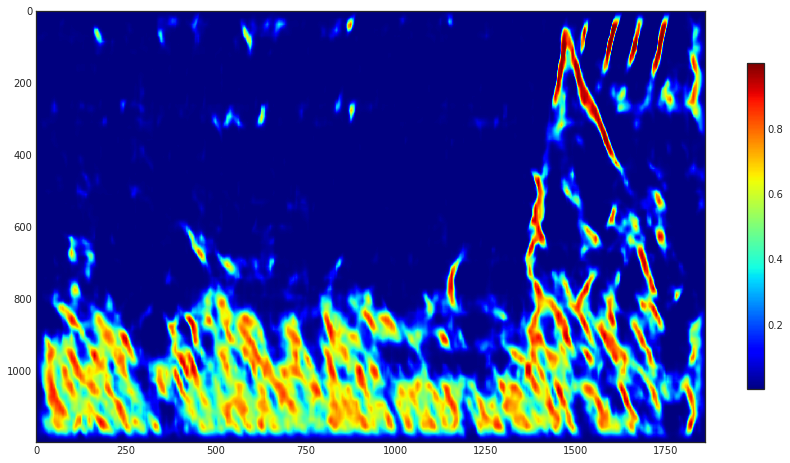

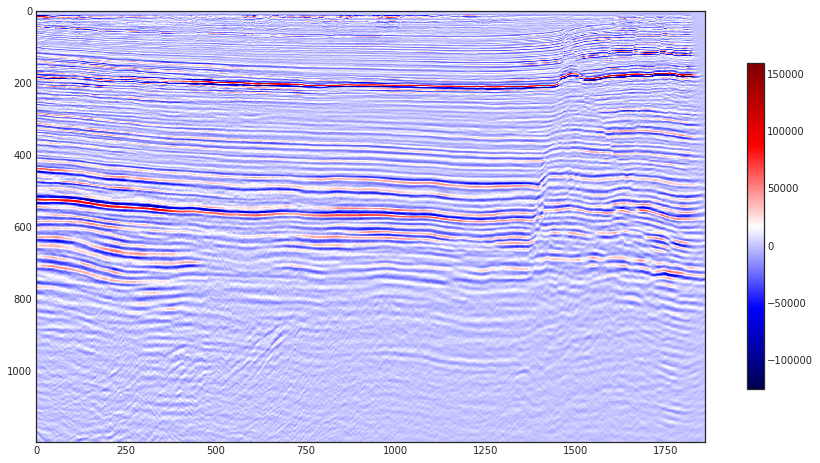

In [22]:
import numpy as np 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,12))
plt.imshow(a,cmap="jet")
plt.colorbar(shrink=0.5)
plt.show()
plt.figure(figsize=(15,12))
plt.imshow(seis[0],cmap='seismic')
plt.colorbar(shrink=0.5)
plt.show()

In [23]:
print(a.max())

0.998862083880904


In [24]:

fin = cv2.addWeighted(a, 0.6, seis_norm[0], 0.4, 0)
plt.figure(figsize=(20,16))
plt.imshow(fin, vmin=0)
plt.axis('off')
# plt.colorbar(shrink=0.5)
plt.show()

error: OpenCV(4.0.0) /io/opencv/modules/core/src/arithm.cpp:687: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'arithm_op'


In [ ]:
heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('jet_r'))
# print(heatmap_img.max(),heatmap_img.min())
# print(heatmap_img)
plt.figure(figsize=(20,16))
plt.imshow(heatmap_img)
plt.axis('off')
# plt.colorbar(shrink=0.5)
plt.show()
fin = cv2.addWeighted(heatmap_img/255, 0.6, img_colorized/255, 0.4, 0)
plt.figure(figsize=(20,16))
plt.imshow(fin, vmin=0)
plt.axis('off')
# plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
break

In [ ]:
thresh = 0.5
below_threshold_indices = a < thresh
a[below_threshold_indices] = 0

In [ ]:
heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('Greens'))
# print(heatmap_img.max(),heatmap_img.min())
# print(heatmap_img)
plt.figure(figsize=(20,16))
plt.imshow(heatmap_img)
plt.axis('off')
# plt.colorbar(shrink=0.5)
plt.show()
fin = cv2.addWeighted(heatmap_img/255, 0.6, img_colorized/255, 0.4, 0)
plt.figure(figsize=(20,16))
plt.imshow(fin, vmin=0)
plt.axis('off')
# plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(20,16))
plt.imshow(a,cmap="jet",vmin=0.2)
plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
print(a.shape,img_colorized.shape)

In [ ]:
print(img_colorized.max(),img_colorized.min())

In [ ]:
print(seis_norm.dtype)

In [ ]:
dic = {"pred_{}".format(k):v for k,v in enumerate(np.squeeze(recover_Y_test_pred), 1)}
print(dic)

In [ ]:
t_start = time.time()
from scipy.io import loadmat, savemat
os.makedirs("testpreds_rgb_mat", exist_ok=True)
for i in range(1861):
    a = np.load(os.path.join("testpreds_rgb","{}.npy".format(i)))
    savemat(os.path.join("testpreds_rgb_mat","{}.mat".format(i)),{'preds':a})
print("read images in {} sec".format(time.time()-t_start))

In [25]:
a = np.load(os.path.join(savepath,"unet_800.npy"))
b = np.load(os.path.join(savepath,"mobilenet_96_48_noaug_800.npy"))
c = np.load(os.path.join(savepath,"hed_96_48_noaug_800.npy"))
d = np.load(os.path.join(savepath,"rcf_800.npy"))

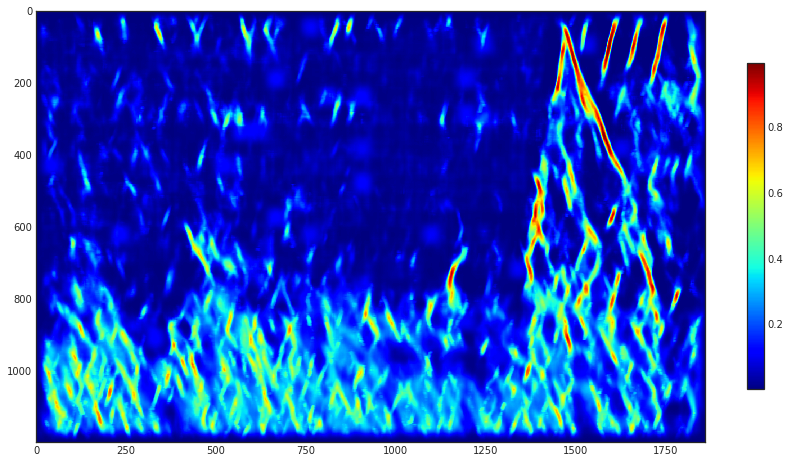

In [31]:
mean = (a+b+c+d)/4
fig = plt.figure(figsize=(15,12))
plt.imshow(mean,cmap="jet")
plt.colorbar(shrink=0.5)
plt.show()

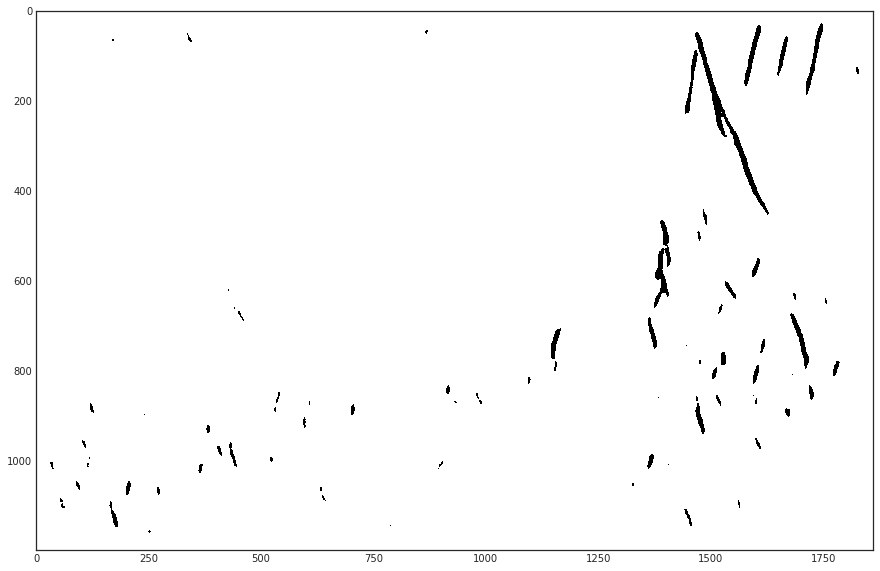

In [34]:
fig = plt.figure(figsize=(15,12))
plt.imshow(mean>0.66)
# plt.colorbar(shrink=0.5)
plt.show()

In [29]:
a1 = np.zeros((3,4))
b1 = np.ones((3,4))
c1 = np.random.randint(0,12,(3,4))
print(a1,b1,c1)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]] [[5 1 5 7]
 [6 4 8 4]
 [7 1 5 3]]


In [30]:
print((a1+b1+c1)/3)

[[2.         0.66666667 2.         2.66666667]
 [2.33333333 1.66666667 3.         1.66666667]
 [2.66666667 0.66666667 2.         1.33333333]]
